En este notebook se evaluan los modelos entrenados. Se carga el data set configurado, y se realiza la unificación de las clases 0-4 para el target. Luego, se realiza la transformación con el pipeline, se cargan los modelos, se scorea, y finalmente se muestran los resultados con una matriz de confusión y ciertos reportes.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')
from utils.eval import *
import joblib

In [3]:
from IPython.core.display import display, HTML
display(
   HTML("<style>.container { width:95% !important; }</style>"))
display(
   HTML("<style>.prompt { font-size: 10px !important; }</style>"))

## Config

In [4]:
cmap = plt.cm.Blues

In [5]:
data = 'test'

## Load data

In [6]:
data_path = "data/"
input_path = data_path + "input/"
models_path = data_path + "models/"
columns_path = data_path + "columns/"
pipelines_path = data_path + "pipelines/"

In [7]:
df = pd.read_csv(input_path + data + '.csv', sep='\t', encoding='utf-8', )  
df.head()

,installments.quantity,installments.rate,id,site_id,title,price,currency_id,available_quantity,sold_quantity,buying_mode,...,address.state_name,shipping.free_shipping,shipping.mode,shipping.logistic_type,shipping.store_pick_up,seller.seller_reputation.real_level,root_category_id,root_category_name,discount,category_name
0,12.0,70.17,MLA901948080,MLA,Estéreo Para Auto Pioneer Mvh S215bt Con Usb Y...,12600.0,ARS,1,5,buy_it_now,...,Buenos Aires,True,me2,drop_off,False,NaN,MLA5725,Accesorios para Vehículos,NaN,Estéreos
1,12.0,70.17,MLA869356478,MLA,Neumático Pirelli Formula Energy 185/60 R14 82h,10250.0,ARS,50,500,buy_it_now,...,Buenos Aires,True,me2,cross_docking,True,NaN,MLA5725,Accesorios para Vehículos,NaN,Neumáticos de Auto y Camioneta
2,12.0,70.17,MLA851109741,MLA,Carcasa Llave Navaja Peugeot 2 Bot 307 308 C/...,799.0,ARS,50,500,buy_it_now,...,Santa Fe,False,me2,fulfillment,False,NaN,MLA5725,Accesorios para Vehículos,NaN,Llaves Telecomando
3,12.0,70.17,MLA851344178,MLA,Kit Llave Carcasa Clio Mio Sandero Duster + Pi...,899.0,ARS,50,500,buy_it_now,...,Santa Fe,False,me2,fulfillment,False,NaN,MLA5725,Accesorios para Vehículos,NaN,Llaves Telecomando
4,12.0,70.17,MLA881234681,MLA,Crique Carrito Gato Hidráulico 2 Tn Incluye Va...,3999.0,ARS,250,500,buy_it_now,...,Buenos Aires,True,me2,fulfillment,False,NaN,MLA5725,Accesorios para Vehículos,NaN,Hidráulicos


In [8]:
df.shape

(7727, 43)

## IDs

In [9]:
id_cols = joblib.load(columns_path + 'id_cols.joblib')
id_cols

['id',
 'site_id',
 'title',
 'category_id',
 'seller.id',
 'catalog_product_id',
 'root_category_id',
 'root_category_name',
 'category_name']

In [10]:
df_ID = df[id_cols].copy()
df = df.drop(id_cols, axis= 1)

## Distribución de valores para el target

In [11]:
df.sold_quantity.value_counts().sort_index()

0         828
1          78
2          62
3          57
4          44
5         589
25        456
50        694
100       524
150       431
200       357
250      1143
500      2269
5000      193
50000       2
Name: sold_quantity, dtype: int64

<AxesSubplot:>

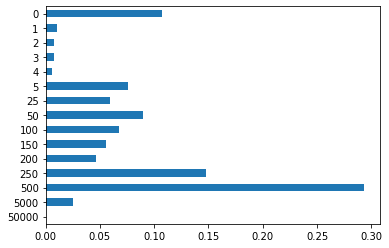

In [12]:
df.sold_quantity.value_counts(normalize=True).sort_index(ascending=False).plot.barh()

## Manipulación clases

In [13]:
df["sold_quantity"] = [x if x >= 5 else 1 for x in df["sold_quantity"]]

In [14]:
df.sold_quantity.value_counts().sort_index()

1        1069
5         589
25        456
50        694
100       524
150       431
200       357
250      1143
500      2269
5000      193
50000       2
Name: sold_quantity, dtype: int64

## Y

In [15]:
y = df.sold_quantity

In [16]:
df = df.drop(['sold_quantity'], axis= 1)

## Paths

In [17]:
cols_path = columns_path + "final_cols.joblib" 
pipeline_path = pipelines_path + "pipeline.joblib" 
models_path_template = models_path + '{}.joblib'

## Load objects

In [18]:
# pipeline
pipeline = joblib.load(pipeline_path)
# cols
cols = joblib.load(cols_path)  


## Transform df

In [19]:
df_copy = df.copy()
df_copy = pipeline.transform(df_copy)

## Load models and predict

In [20]:
models = [ 'xgb', 
           'mlp', 
           'lr' 
]

In [21]:
dict_res = {}
for k in models:
    dict_res[k] = {}
    # ----------------- load model -------------------
    model = get_model(k, models_path_template.format(k))
    # ----------------- get preds -------------------
    preds = model.predict(df_copy[cols])
    dict_res[k]['model'] = model
    dict_res[k]['preds'] = preds

## --------------------------- <p style='color:blue; font-weight:bold'> XGB </p> ---------------------------

In [22]:
dict_res['xgb']['model']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=7, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=1111, subsample=1,
              tree_method='auto', validate_parameters=1, verbosity=None)

In [23]:
predicted_classes = dict_res['xgb']['preds']

In [24]:
classes = np.unique(predicted_classes)
classes

array([    1,     5,    25,    50,   100,   150,   200,   250,   500,
        5000, 50000])

In [25]:
print_pred_classes_prop(predicted_classes)

Predicted classes proportions
--------------
1        0.130063
5        0.088391
25       0.045555
50       0.102886
100      0.044778
150      0.022389
200      0.012424
250      0.125534
500      0.416850
5000     0.010871
50000    0.000259
dtype: float64 



Confusion matrix, without normalization


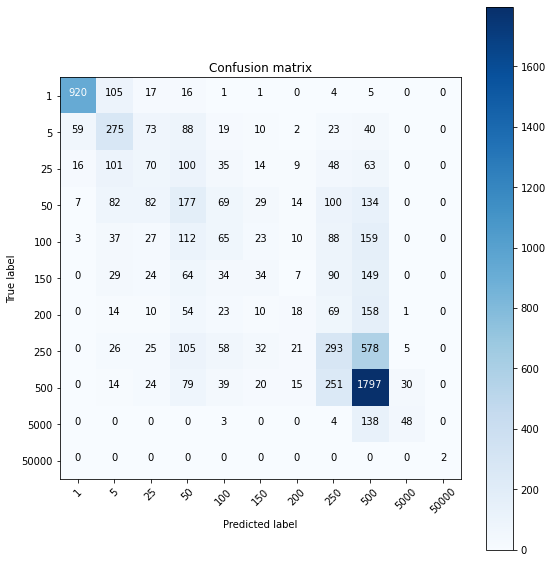

In [26]:
make_cmx(y, predicted_classes, classes, cmap=cmap)

In [27]:
make_classif_report(y, predicted_classes, classes)

,precision,recall,f1-score,support
1,0.92,0.86,0.89,1069.00
5,0.40,0.47,0.43,589.00
25,0.20,0.15,0.17,456.00
50,0.22,0.26,0.24,694.00
100,0.19,0.12,0.15,524.00
150,0.20,0.08,0.11,431.00
200,0.19,0.05,0.08,357.00
250,0.30,0.26,0.28,1143.00
500,0.56,0.79,0.65,2269.00
5000,0.57,0.25,0.35,193.00


## --------------------------- <p style='color:blue; font-weight:bold'> LR </p> ---------------------------

In [28]:
dict_res['lr']['model']

LogisticRegression(C=10, class_weight='balanced', multi_class='ovr',
                   random_state=1111, solver='saga')

In [29]:
predicted_classes = dict_res['lr']['preds']

In [30]:
classes = np.unique(predicted_classes)
classes

array([    1,     5,    25,    50,   100,   150,   200,   250,   500,
        5000, 50000], dtype=int64)

In [31]:
print_pred_classes_prop(predicted_classes)

Predicted classes proportions
--------------
1        0.111686
5        0.169406
25       0.029895
50       0.096415
100      0.058496
150      0.034166
200      0.103533
250      0.057331
500      0.239032
5000     0.085544
50000    0.014495
dtype: float64 



Confusion matrix, without normalization


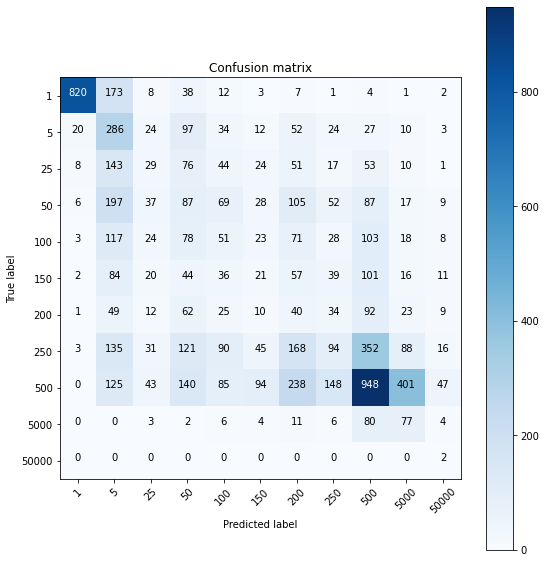

In [32]:
make_cmx(y, predicted_classes, classes, cmap=cmap)

In [33]:
make_classif_report(y, predicted_classes, classes)


,precision,recall,f1-score,support
1,0.95,0.77,0.85,1069.00
5,0.22,0.49,0.30,589.00
25,0.13,0.06,0.08,456.00
50,0.12,0.13,0.12,694.00
100,0.11,0.10,0.10,524.00
150,0.08,0.05,0.06,431.00
200,0.05,0.11,0.07,357.00
250,0.21,0.08,0.12,1143.00
500,0.51,0.42,0.46,2269.00
5000,0.12,0.40,0.18,193.00


## --------------------------- <p style='color:blue; font-weight:bold'> MLP </p> ---------------------------

In [34]:
dict_res['mlp']['model']

MLPClassifier(alpha=0.001, batch_size=64,
              hidden_layer_sizes=(64, 64, 64, 64, 64), learning_rate='adaptive',
              learning_rate_init=0.01, max_iter=1800, random_state=1111,
              solver='sgd')

In [35]:
predicted_classes = dict_res['mlp']['preds']

In [36]:
classes = np.unique(predicted_classes)
classes

array([    1,     5,    25,    50,   100,   150,   200,   250,   500,
        5000, 50000], dtype=int64)

In [37]:
print_pred_classes_prop(predicted_classes)

Predicted classes proportions
--------------
1        0.126440
5        0.094992
25       0.055778
50       0.101204
100      0.072344
150      0.049049
200      0.040248
250      0.130840
500      0.308917
5000     0.020060
50000    0.000129
dtype: float64 



Confusion matrix, without normalization


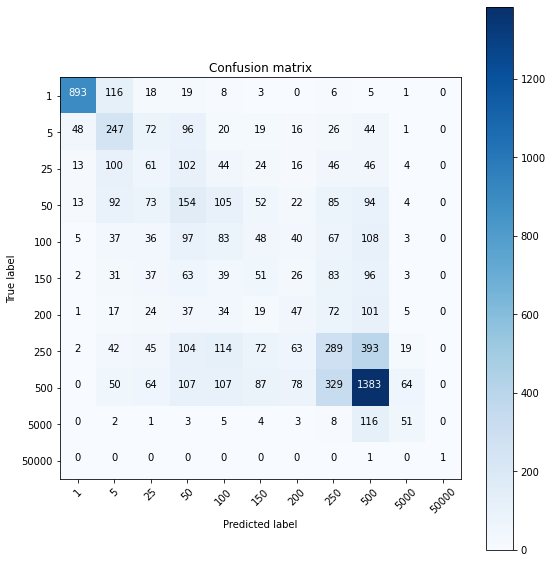

In [38]:
make_cmx(y, predicted_classes, classes, cmap=cmap)

In [39]:
make_classif_report(y, predicted_classes, classes)

,precision,recall,f1-score,support
1,0.91,0.84,0.87,1069.00
5,0.34,0.42,0.37,589.00
25,0.14,0.13,0.14,456.00
50,0.20,0.22,0.21,694.00
100,0.15,0.16,0.15,524.00
150,0.13,0.12,0.13,431.00
200,0.15,0.13,0.14,357.00
250,0.29,0.25,0.27,1143.00
500,0.58,0.61,0.59,2269.00
5000,0.33,0.26,0.29,193.00
